In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html



2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 57.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.2 MB/s eta 0:00:00


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
import math

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
from torch.nn import ReLU, Sequential
from torch import sigmoid
from itertools import chain
from time import perf_counter
import csv



from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mutag_dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)
print(torch.cuda.is_available())
checkpoint_directory_Classifier = "/content/drive/My Drive/Check gpu/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

#File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

cuda
True


In [6]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes_MUTAG.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

mutag_train_dataset = []
mutag_test_dataset = []
for index in read_training_list_indexes:
    mutag_train_dataset.append(mutag_dataset[index])
for index in read_test_list_indexes:
    mutag_test_dataset.append(mutag_dataset[index])


print(f'Number of training graphs: {len(mutag_train_dataset)}')
print(f'Number of test graphs: {len(mutag_test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]
Number of training graphs: 150
Number of test graphs: 38


In [7]:
BATCH_SIZE = 64
mutag_train_dataloader = DataLoader(mutag_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
mutag_test_dataloader = DataLoader(mutag_test_dataset, batch_size=1, shuffle=False)

In [8]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

# import GCN_plus_GAP as Graph_Network
# GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
#                                        num_hid_layers=3, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
#                                        dropout_rate=classifier_dropout).to(device)

import DGCNN as dgcnn_model
GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, node_feat_size=7, mlp_act_fun='ReLu',
                                    dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=17,
                                    hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1]).to(device)

# import DIFFPOOL as diffpool_model
# GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, num_classes=2, embedding_num_block_layers=1, embedding_hid_dim=64,
#                                           new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
#                                           assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
#                                           concat_neighborhood=False, Weight_Initializer=1, Bias=classifier_bias, dropout_rate=0,
#                                           normalize_graphsage=False, aggregation="mean", act_fun="ReLu", num_pooling=1,
#                                           concat_diffpools_outputs=True, pooling="mean").to(device)


# import GIN as gin_model
# GNN_Model = gin_model.GIN_Model(mlp_output_dim=2, mlp_input_dim=7, mlp_hid_dim=7, num_mlp_layers=4,
#                                 Bias=classifier_bias, mlp_act_fun="ReLu", dropout_rate=classifier_dropout, num_slp_layers=2,
#                                 Weight_Initializer=1, joint_embeddings=False).to(device)


Model_name = GNN_Model.__class__.__name__
print("Model_name: ", Model_name)


tanh is Selected.
tanh is Selected.
Model_name:  DGCNN_Model


In [9]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [11]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [12]:
def train_step(data):
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in data:
        batch_of_graphs = batch_of_graphs.to(device)
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            batch_loss = loss_calculations(soft, batch_of_graphs.y)
            Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
            Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, prediction_output_before_soft, prediction_output = GNN_Model(batch_of_graphs, None)
            Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
            batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)

        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)
            Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())
        else:
            raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [13]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index, data):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step(data)
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}, Accuracy: {training_acc:.2f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
        #  torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.6918, Accuracy: 0.70
Epoch: 002, Model Loss: 0.6860, Accuracy: 0.67
Epoch: 003, Model Loss: 0.6724, Accuracy: 0.67
Epoch: 004, Model Loss: 0.6520, Accuracy: 0.67
Epoch: 005, Model Loss: 0.6194, Accuracy: 0.67
Epoch: 006, Model Loss: 0.5891, Accuracy: 0.67
Epoch: 007, Model Loss: 0.5782, Accuracy: 0.67
Epoch: 008, Model Loss: 0.5649, Accuracy: 0.67
Epoch: 009, Model Loss: 0.5382, Accuracy: 0.73
Epoch: 010, Model Loss: 0.5600, Accuracy: 0.79
Epoch: 011, Model Loss: 0.5051, Accuracy: 0.83
Epoch: 012, Model Loss: 0.4763, Accuracy: 0.83
Epoch: 013, Model Loss: 0.4625, Accuracy: 0.85
Epoch: 014, Model Loss: 0.4441, Accuracy: 0.84
Epoch: 015, Model Loss: 0.4254, Accuracy: 0.86
Epoch: 016, Model Loss: 0.4382, Accuracy: 0.84
Epoch: 017, Model Loss: 0.4217, Accuracy: 0.85
Epoch: 018, Model Loss: 0.4317, Accuracy: 0.85
Epoch: 019, Model Loss: 0.4177, Accuracy: 0.87
Epoch: 020, Model Loss: 0.4772, Accuracy: 0.82
Epoch: 021, Model Loss: 0.4245, Accuracy: 0.86
Epoch: 022, M

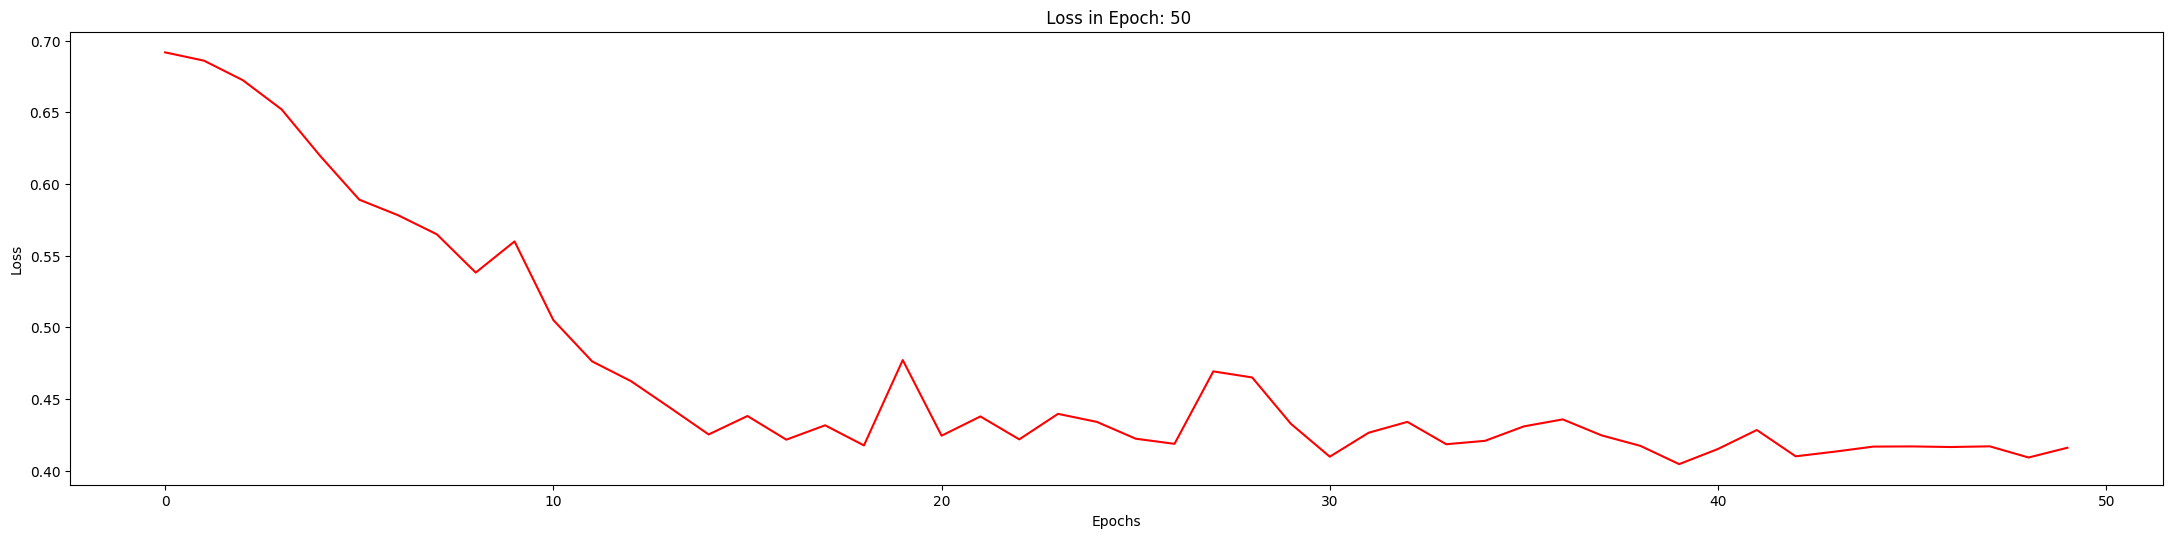

Epoch: 051, Model Loss: 0.4158, Accuracy: 0.88
Epoch: 052, Model Loss: 0.4091, Accuracy: 0.88
Epoch: 053, Model Loss: 0.4029, Accuracy: 0.89
Epoch: 054, Model Loss: 0.4195, Accuracy: 0.88
Epoch: 055, Model Loss: 0.4071, Accuracy: 0.89
Epoch: 056, Model Loss: 0.4158, Accuracy: 0.88
Epoch: 057, Model Loss: 0.4119, Accuracy: 0.88
Epoch: 058, Model Loss: 0.4120, Accuracy: 0.88
Epoch: 059, Model Loss: 0.4083, Accuracy: 0.88
Epoch: 060, Model Loss: 0.4055, Accuracy: 0.88
Epoch: 061, Model Loss: 0.4085, Accuracy: 0.87
Epoch: 062, Model Loss: 0.4160, Accuracy: 0.88
Epoch: 063, Model Loss: 0.4157, Accuracy: 0.88
Epoch: 064, Model Loss: 0.4051, Accuracy: 0.89
Epoch: 065, Model Loss: 0.4164, Accuracy: 0.88
Epoch: 066, Model Loss: 0.4164, Accuracy: 0.88
Epoch: 067, Model Loss: 0.4004, Accuracy: 0.89
Epoch: 068, Model Loss: 0.4048, Accuracy: 0.89
Epoch: 069, Model Loss: 0.4106, Accuracy: 0.89
Epoch: 070, Model Loss: 0.4177, Accuracy: 0.88
Epoch: 071, Model Loss: 0.4125, Accuracy: 0.88
Epoch: 072, M

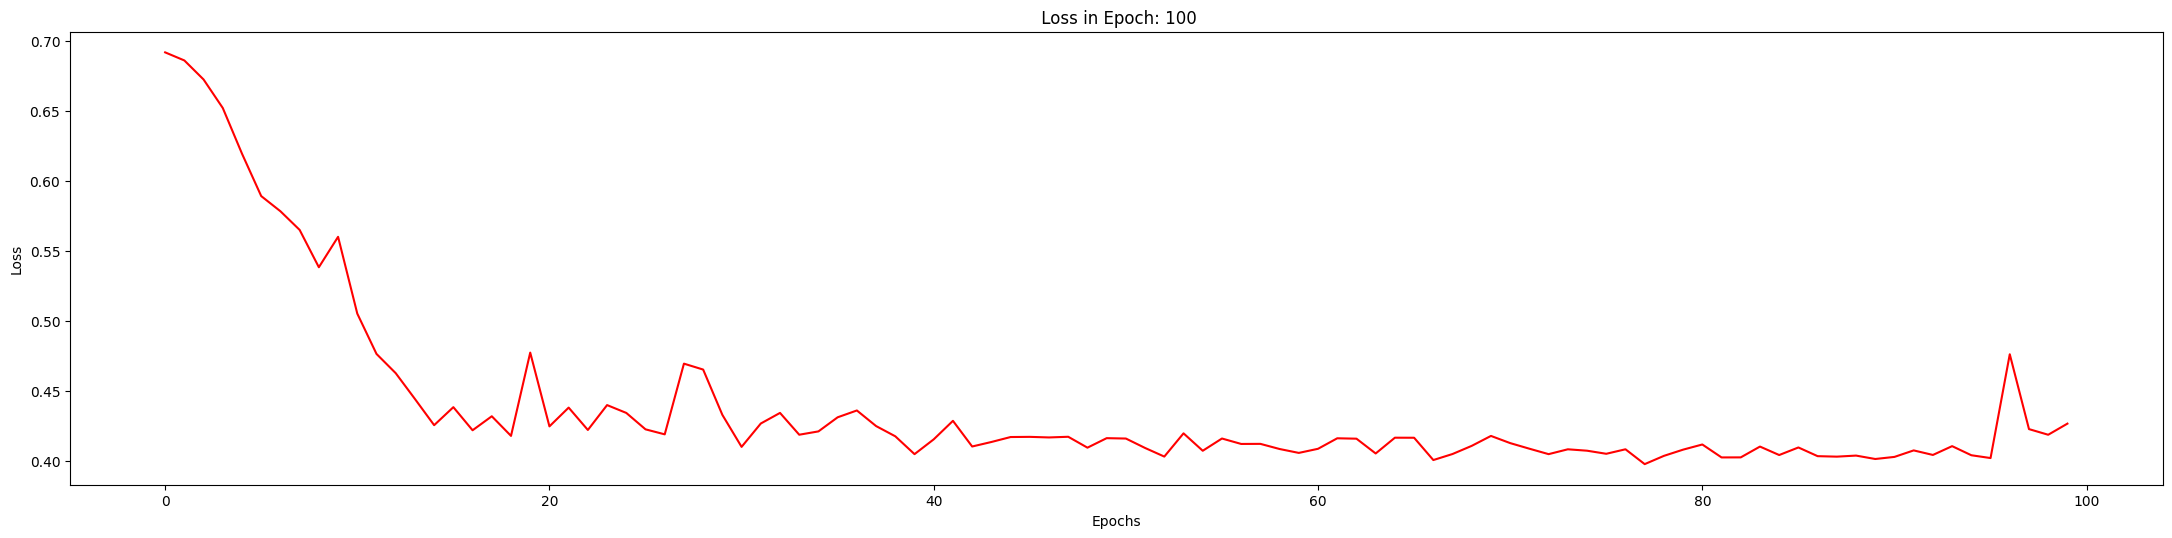

Epoch: 101, Model Loss: 0.4260, Accuracy: 0.87
Epoch: 102, Model Loss: 0.4259, Accuracy: 0.87
Epoch: 103, Model Loss: 0.4265, Accuracy: 0.87
Epoch: 104, Model Loss: 0.4191, Accuracy: 0.88
Epoch: 105, Model Loss: 0.4184, Accuracy: 0.88
Epoch: 106, Model Loss: 0.4187, Accuracy: 0.88
Epoch: 107, Model Loss: 0.4166, Accuracy: 0.88
Epoch: 108, Model Loss: 0.4101, Accuracy: 0.88
Epoch: 109, Model Loss: 0.4065, Accuracy: 0.88
Epoch: 110, Model Loss: 0.4148, Accuracy: 0.87
Epoch: 111, Model Loss: 0.4158, Accuracy: 0.88
Epoch: 112, Model Loss: 0.4110, Accuracy: 0.89
Epoch: 113, Model Loss: 0.3949, Accuracy: 0.89
Epoch: 114, Model Loss: 0.3903, Accuracy: 0.91
Epoch: 115, Model Loss: 0.3965, Accuracy: 0.90
Epoch: 116, Model Loss: 0.3915, Accuracy: 0.90
Epoch: 117, Model Loss: 0.3896, Accuracy: 0.90
Epoch: 118, Model Loss: 0.3931, Accuracy: 0.91
Epoch: 119, Model Loss: 0.3976, Accuracy: 0.89
Epoch: 120, Model Loss: 0.3919, Accuracy: 0.90
Epoch: 121, Model Loss: 0.3871, Accuracy: 0.91
Epoch: 122, M

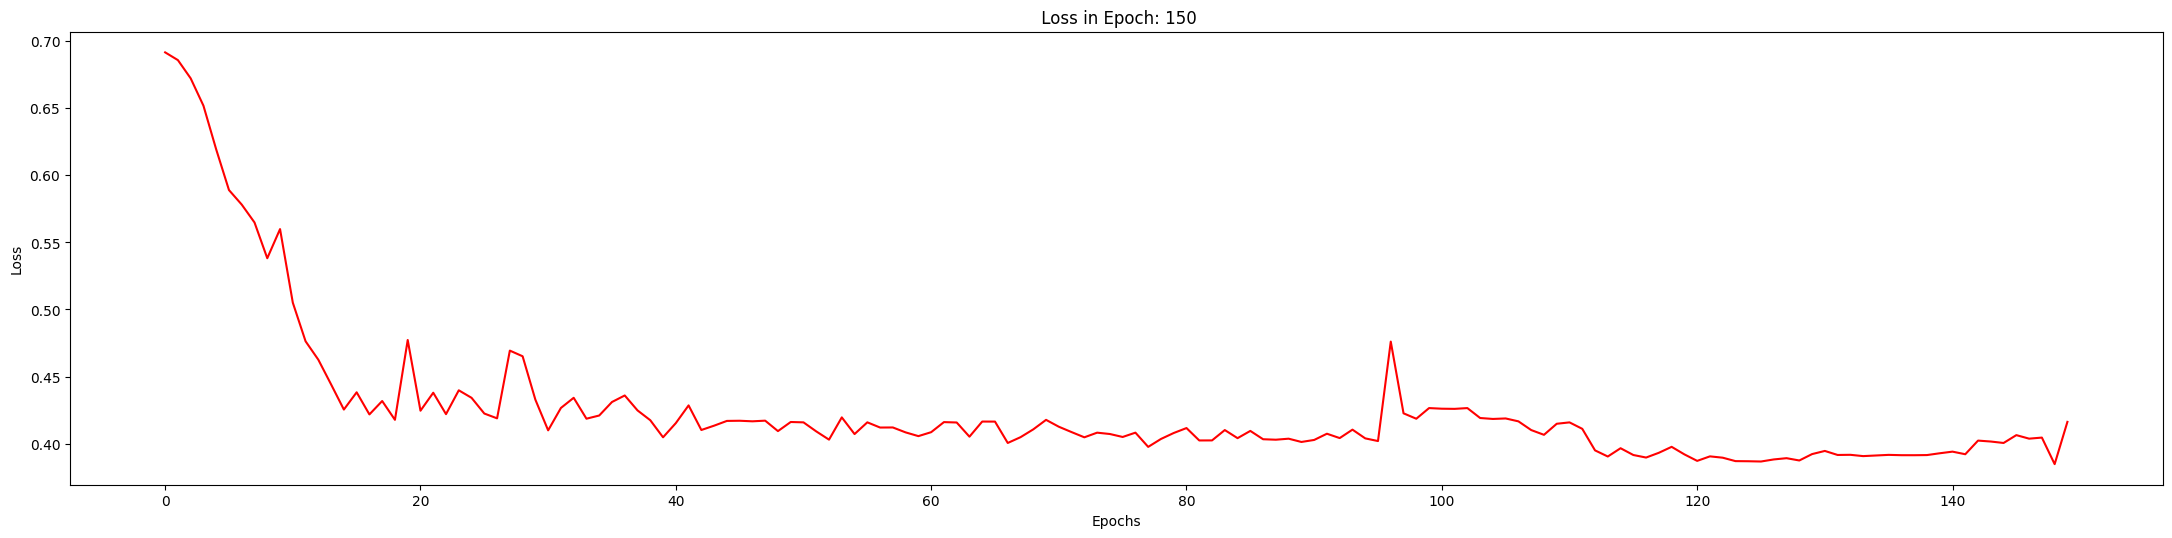

Epoch: 151, Model Loss: 0.4562, Accuracy: 0.85
Epoch: 152, Model Loss: 0.5481, Accuracy: 0.74
Epoch: 153, Model Loss: 0.4856, Accuracy: 0.81
Epoch: 154, Model Loss: 0.4469, Accuracy: 0.85
Epoch: 155, Model Loss: 0.4877, Accuracy: 0.80
Epoch: 156, Model Loss: 0.4409, Accuracy: 0.85
Epoch: 157, Model Loss: 0.4105, Accuracy: 0.89
Epoch: 158, Model Loss: 0.4258, Accuracy: 0.87
Epoch: 159, Model Loss: 0.4220, Accuracy: 0.87
Epoch: 160, Model Loss: 0.4343, Accuracy: 0.86
Epoch: 161, Model Loss: 0.4248, Accuracy: 0.85
Epoch: 162, Model Loss: 0.4237, Accuracy: 0.87
Epoch: 163, Model Loss: 0.4274, Accuracy: 0.87
Epoch: 164, Model Loss: 0.4613, Accuracy: 0.85
Epoch: 165, Model Loss: 0.4456, Accuracy: 0.85
Epoch: 166, Model Loss: 0.4480, Accuracy: 0.84
Epoch: 167, Model Loss: 0.4220, Accuracy: 0.87
Epoch: 168, Model Loss: 0.4221, Accuracy: 0.87
Epoch: 169, Model Loss: 0.4242, Accuracy: 0.87
Epoch: 170, Model Loss: 0.4197, Accuracy: 0.87
Epoch: 171, Model Loss: 0.4100, Accuracy: 0.89
Epoch: 172, M

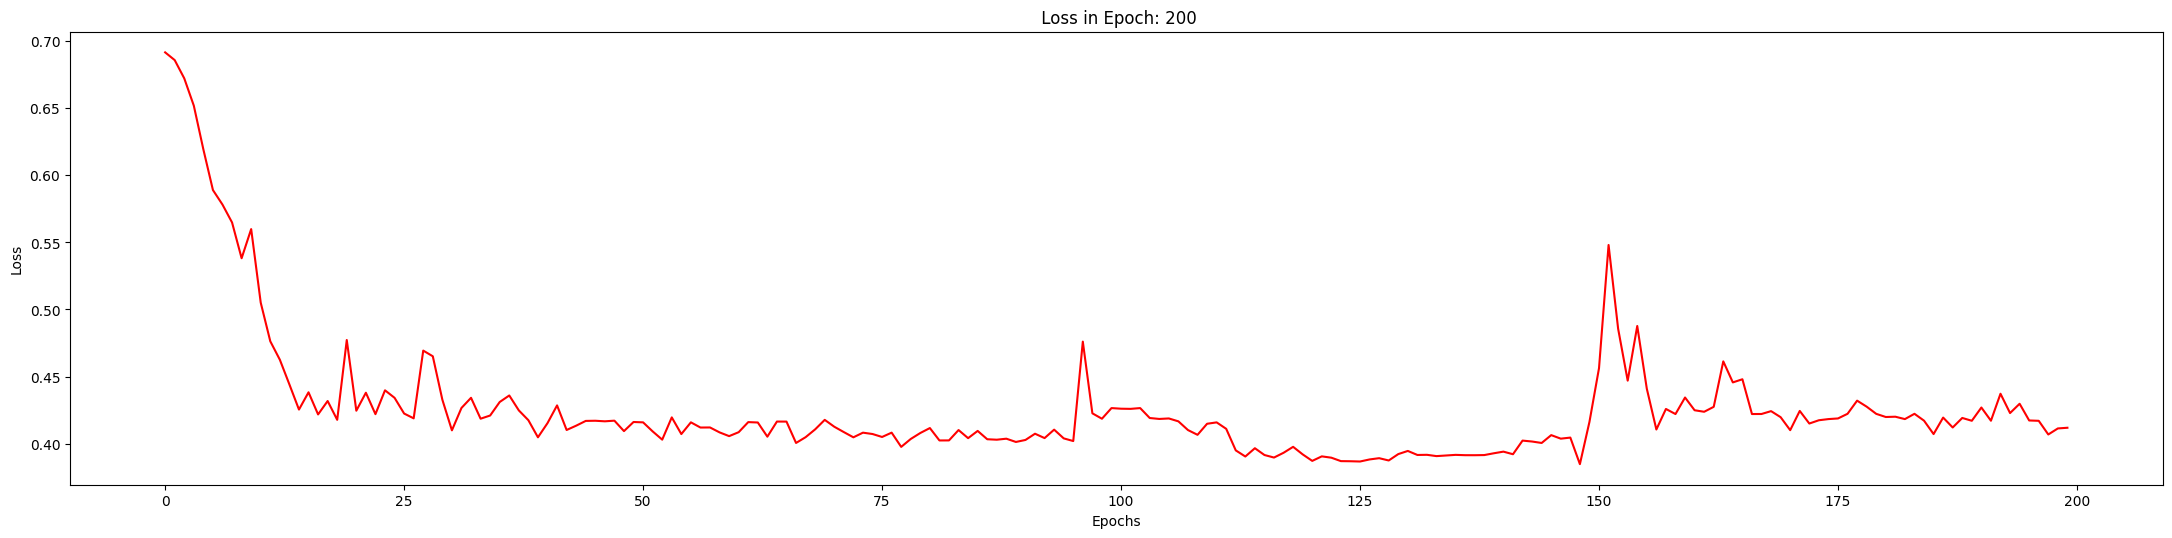

Epoch: 201, Model Loss: 0.4069, Accuracy: 0.89
Epoch: 202, Model Loss: 0.4168, Accuracy: 0.88
Epoch: 203, Model Loss: 0.4137, Accuracy: 0.89
Epoch: 204, Model Loss: 0.4096, Accuracy: 0.89
Epoch: 205, Model Loss: 0.4066, Accuracy: 0.89
Epoch: 206, Model Loss: 0.4070, Accuracy: 0.89
Epoch: 207, Model Loss: 0.4093, Accuracy: 0.89
Epoch: 208, Model Loss: 0.4066, Accuracy: 0.89
Epoch: 209, Model Loss: 0.4037, Accuracy: 0.90
Epoch: 210, Model Loss: 0.4065, Accuracy: 0.89
Epoch: 211, Model Loss: 0.4016, Accuracy: 0.90
Epoch: 212, Model Loss: 0.4013, Accuracy: 0.90
Epoch: 213, Model Loss: 0.4063, Accuracy: 0.89
Epoch: 214, Model Loss: 0.4021, Accuracy: 0.90
Epoch: 215, Model Loss: 0.4013, Accuracy: 0.90
Epoch: 216, Model Loss: 0.4050, Accuracy: 0.89
Epoch: 217, Model Loss: 0.4032, Accuracy: 0.90
Epoch: 218, Model Loss: 0.4068, Accuracy: 0.89
Epoch: 219, Model Loss: 0.4106, Accuracy: 0.89
Epoch: 220, Model Loss: 0.4016, Accuracy: 0.90
Epoch: 221, Model Loss: 0.4015, Accuracy: 0.90
Epoch: 222, M

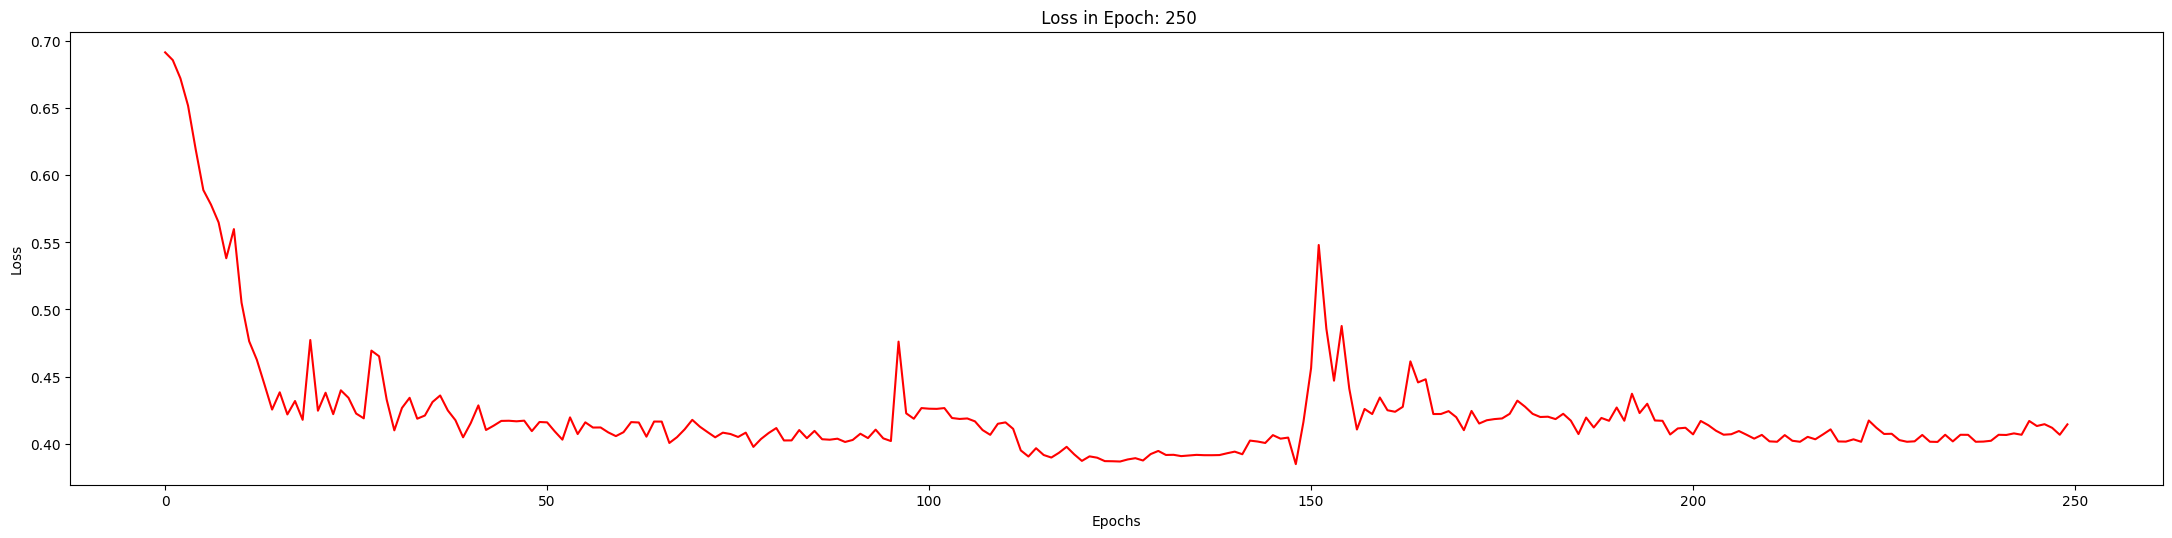

Epoch: 251, Model Loss: 0.4119, Accuracy: 0.89
Epoch: 252, Model Loss: 0.4038, Accuracy: 0.89
Epoch: 253, Model Loss: 0.4119, Accuracy: 0.89
Epoch: 254, Model Loss: 0.4202, Accuracy: 0.86
Epoch: 255, Model Loss: 0.4108, Accuracy: 0.88
Epoch: 256, Model Loss: 0.4373, Accuracy: 0.87
Epoch: 257, Model Loss: 0.4170, Accuracy: 0.88
Epoch: 258, Model Loss: 0.4170, Accuracy: 0.88
Epoch: 259, Model Loss: 0.4170, Accuracy: 0.88
Epoch: 260, Model Loss: 0.4233, Accuracy: 0.87
Epoch: 261, Model Loss: 0.4218, Accuracy: 0.87
Epoch: 262, Model Loss: 0.4117, Accuracy: 0.89
Epoch: 263, Model Loss: 0.3953, Accuracy: 0.90
Epoch: 264, Model Loss: 0.4013, Accuracy: 0.90
Epoch: 265, Model Loss: 0.4013, Accuracy: 0.90
Epoch: 266, Model Loss: 0.4010, Accuracy: 0.90
Epoch: 267, Model Loss: 0.4085, Accuracy: 0.89
Epoch: 268, Model Loss: 0.3985, Accuracy: 0.90
Epoch: 269, Model Loss: 0.4178, Accuracy: 0.88
Epoch: 270, Model Loss: 0.4170, Accuracy: 0.88
Epoch: 271, Model Loss: 0.4223, Accuracy: 0.88
Epoch: 272, M

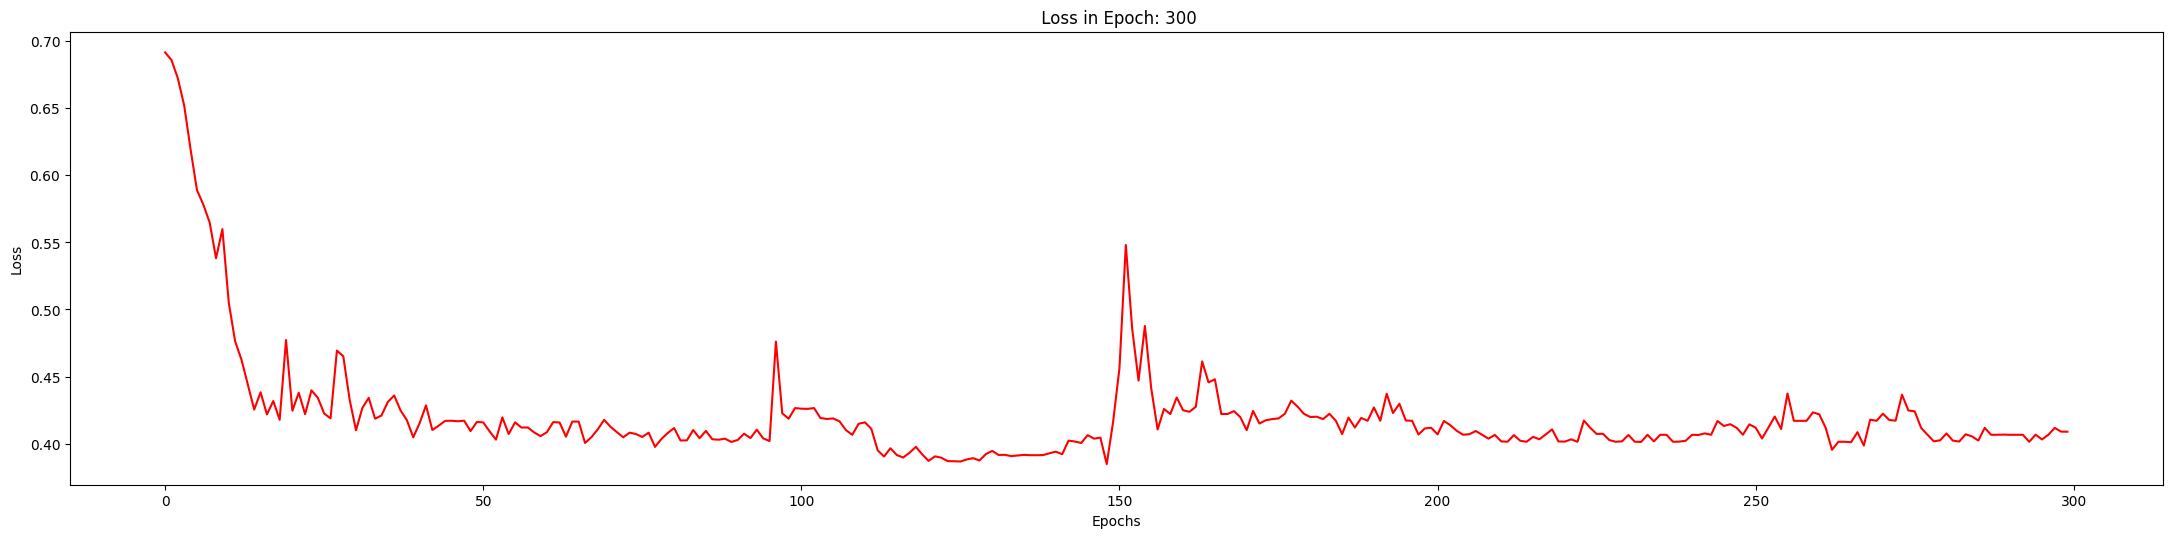

In [14]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index, mutag_train_dataloader)